In [1]:
# Step 1: Importing Libraries

import warnings
warnings.filterwarnings("ignore")
import os
from dotenv import load_dotenv, find_dotenv
import weaviate, os
from weaviate.classes.init import Auth

In [2]:
# Step 2: Load Environment Variables
# print(find_dotenv("HOME.env", raise_error_if_not_found=True))

# Load the Weviate API Key file but beware because the project will last for 14 days only so you may 
# need to create a new project after that period.

env_path = find_dotenv("HOME.env", raise_error_if_not_found=True)
load_dotenv(env_path)
EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_APIKEY")
WEAVIATE_URL = os.getenv("WEAVIATE_URL")
VERTEX_AI_KEY = os.getenv("VERTEX_AI_KEY")
COHERE_API_KEY = os.getenv("COHERE_API_KEY")
NVDA_API_KEY = os.getenv("NVDA_API_KEY")
VoyagerAI_API_KEY = os.getenv("VoyagerAI_API_KEY")

# Simple API Test

#print("VOYAGERAI_API_KEY:", VoyagerAI_API_KEY)
#print("EMBEDDING_API_KEY:", NVDA_API_KEY)


In [3]:
# Step 3: Connect to Weviate
# You cannot use Gemini's API on Cloud Version - https://docs.weaviate.io/weaviate/model-providers/google/embeddings-multimodal
# Alternate models headers you could use are: VoyageAI, Cohere, NVDA

NVDA_API_KEY = os.getenv("NVDA_API_KEY")

headers = {
    
    "X-NVIDIA-Api-Key": NVDA_API_KEY,
}
# Connection to Weaviate Cloud
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=WEAVIATE_URL,
    auth_credentials=Auth.api_key(EMBEDDING_API_KEY),
    headers = headers
)

print(client.is_ready())
client.close()

#Always Close your client by using client.close()


True


In [ ]:
# Step 4: The Create method has depreciated if you are using Gemini as a header but is still functional as of today, 25th October
# Look at Step 3, 1st Comment for more details on headers and models
# You can also use vectorizer_config instead of vector_config for Voyageai models

from weaviate.classes.config import Configure, DataType, Multi2VecField, Property

# Check if collection exists, if yes delete it.
if(client.collections.exists("Ferrari")):
    client.collections.delete("Ferrari")


client.collections.create(
    name="Ferrari",
    description="Ferrari Models",
    properties=[
        Property(name="model_name", description="Name of the Ferrari Model", data_type=DataType.TEXT),
        Property(name="model_image", description="Ferrari Model", data_type=DataType.BLOB),
        Property(name="path", description="File path for display", data_type=DataType.TEXT),
        Property(name="mediaType", description="Type of media", data_type=DataType.TEXT)
    ],
    vectorizer_config=Configure.Vectorizer.multi2vec_nvidia(
        image_fields=[Multi2VecField(name="model_image", weight=0.9)],
        text_fields=[Multi2VecField(name="model_name", weight=0.1)],
        model="nvidia/nvclip",  # You can use nvolveqa_40k if it is enabled for your API Key
    )
)

# Additional optional parameters for NVIDIA, Cohere, VoyageAI models:    
            
# model="voyage-multimodal-3",
# truncation="true",  # or "false",
# output_encoding="base64", # or "null"
 # base_url="<custom_voyageai_url>"

In [23]:
# Step 5: Use Base64 to encode binary data (documents, images, videos) to ASCII characters and decode back to Base64
# for storage and validation as a text format for Weaviate ingestion

import base64
from base64 import b64encode, b64decode

# Helper function to convert a file to base64 representation
def toBase64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

In [ ]:
# Step 6: Ingest Data into Weaviate Collection

from weaviate.classes.config import Configure


Ferrari_Models = client.collections.use("Ferrari")

source = os.listdir("./assets/")
print(source)

with Ferrari_Models.batch.rate_limit(requests_per_minute=100) as batch:
    for name in source:
        print(f"Adding:", name)
        path = "./assets/" + name
        
        batch.add_object({
            "model_name": name,   # Ferrari Model Name
            "path": path,            # {File path for display}
            "model_image": toBase64(path),
            "mediaType": "image",
                     
        })

        #model_b64 = b64encode(file["file_path"])
    


['Ferrari_12Cilindri.jpg', 'Ferrari_246_Dino.jpg', 'Ferrari_250GT_Tour_de_France.jpg', 'Ferrari_250_GTO_1962.jpg', 'Ferrari_250_Testarossa.jpg', 'Ferrari_296_GT3.jpg', 'Ferrari_308_GTB.jpg', 'Ferrari_348_GT_Competizione.jpg', 'Ferrari_360.jpg', 'Ferrari_365_GTB4_Daytona.jpg', 'Ferrari_458_Italia.jpg', 'Ferrari_499P.jpeg', 'Ferrari_599GTO.jpg', 'Ferrari_599XX_Evo.png', 'Ferrari_625_F1.jpg', 'Ferrari_Dino.jpg', 'Ferrari_Enzo.jpg', 'Ferrari_F355_GTS.jpg', 'Ferrari_F40.jpg', 'Ferrari_F80.jpg', 'Ferrari_F8_Tributo.jpg', 'Ferrari_F90_Stradale.jpg', 'Ferrari_FF.jpg', 'Ferrari_LaFerrari.jpg', 'Ferrari_Purosangue.jpg', 'Ferrari_Roma.jpg', 'Ferrari_SF90XX_Stradale.jpg', 'Ferrari_SF90_Stradale.jpg']
Adding: Ferrari_12Cilindri.jpg
Adding: Ferrari_246_Dino.jpg
Adding: Ferrari_250GT_Tour_de_France.jpg
Adding: Ferrari_250_GTO_1962.jpg
Adding: Ferrari_250_Testarossa.jpg
Adding: Ferrari_296_GT3.jpg
Adding: Ferrari_308_GTB.jpg
Adding: Ferrari_348_GT_Competizione.jpg
Adding: Ferrari_360.jpg
Adding: Ferra

In [48]:
# Step 7: Check for any failed data ingestions into Weaviate Collection

if len(Ferrari_Models.batch.failed_objects) > 0:
    print(f"Failed to import {len(Ferrari_Models.batch.failed_objects)} objects")
    for failed in Ferrari_Models.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("No errors")

No errors


In [ ]:
# Aggregation of Ferrari Models

agg = Ferrari_Models.aggregate.over_all(
    group_by="mediaType"
)
for group in agg.groups:
    print("Group:", group)
    print("Total objects in Ferrari collection:", agg)

Group: AggregateGroup(grouped_by=GroupedBy(prop='mediaType', value='image'), properties={}, total_count=28)
Total objects in Ferrari collection: AggregateGroupByReturn(groups=[AggregateGroup(grouped_by=GroupedBy(prop='mediaType', value='image'), properties={}, total_count=28)])


In [ ]:
# Step 8: Create Helper functions to display results

import json
from IPython.display import Image, Video

def json_print(data):
    print(json.dumps(data, indent=2))

def display_media(item):
    path = item["path"]

    if(item["mediaType"] == "image"):
        display(Image(path, width=300))

    elif(item["mediaType"] == "video"):
        display(Video(path, width=300))
    

In [51]:
# Step 9: Use helper functions to convert images from URL or local file to base64

import base64, requests

# Helper function – get base64 representation from an online image
def url_to_base64(url):
    image_response = requests.get(url)
    content = image_response.content
    return base64.b64encode(content).decode('utf-8')

# Helper function - get base64 representation from a local file
def file_to_base64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

In [76]:
#Step 10: Text to Image Search

Ferrari_Search = client.collections.get("Ferrari")

response = Ferrari_Search.query.near_text(
    query="Ferrari_F80",
    return_properties=['model_name','path','mediaType'],
    limit=3
)

{
  "path": "./assets/Ferrari_F8_Tributo.jpg",
  "model_name": "Ferrari_F8_Tributo.jpg",
  "mediaType": "image"
}


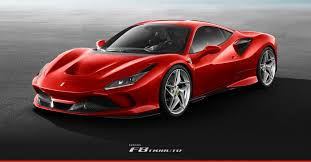

{
  "path": "./assets/Ferrari_LaFerrari.jpg",
  "model_name": "Ferrari_LaFerrari.jpg",
  "mediaType": "image"
}


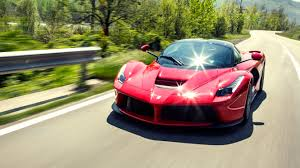

{
  "path": "./assets/Ferrari_F40.jpg",
  "model_name": "Ferrari_F40.jpg",
  "mediaType": "image"
}


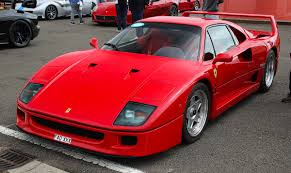

In [77]:
for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

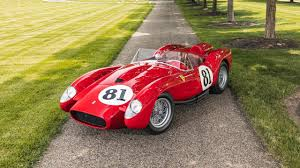

In [ ]:
# Step 11: Local Image Search 
Image("C:/Users/user/Downloads/Ferrari_Model.jpg", width=300)

Found 3 results:

{
  "path": "./assets/Ferrari_250_Testarossa.jpg",
  "model_name": "Ferrari_250_Testarossa.jpg",
  "mediaType": "image"
}


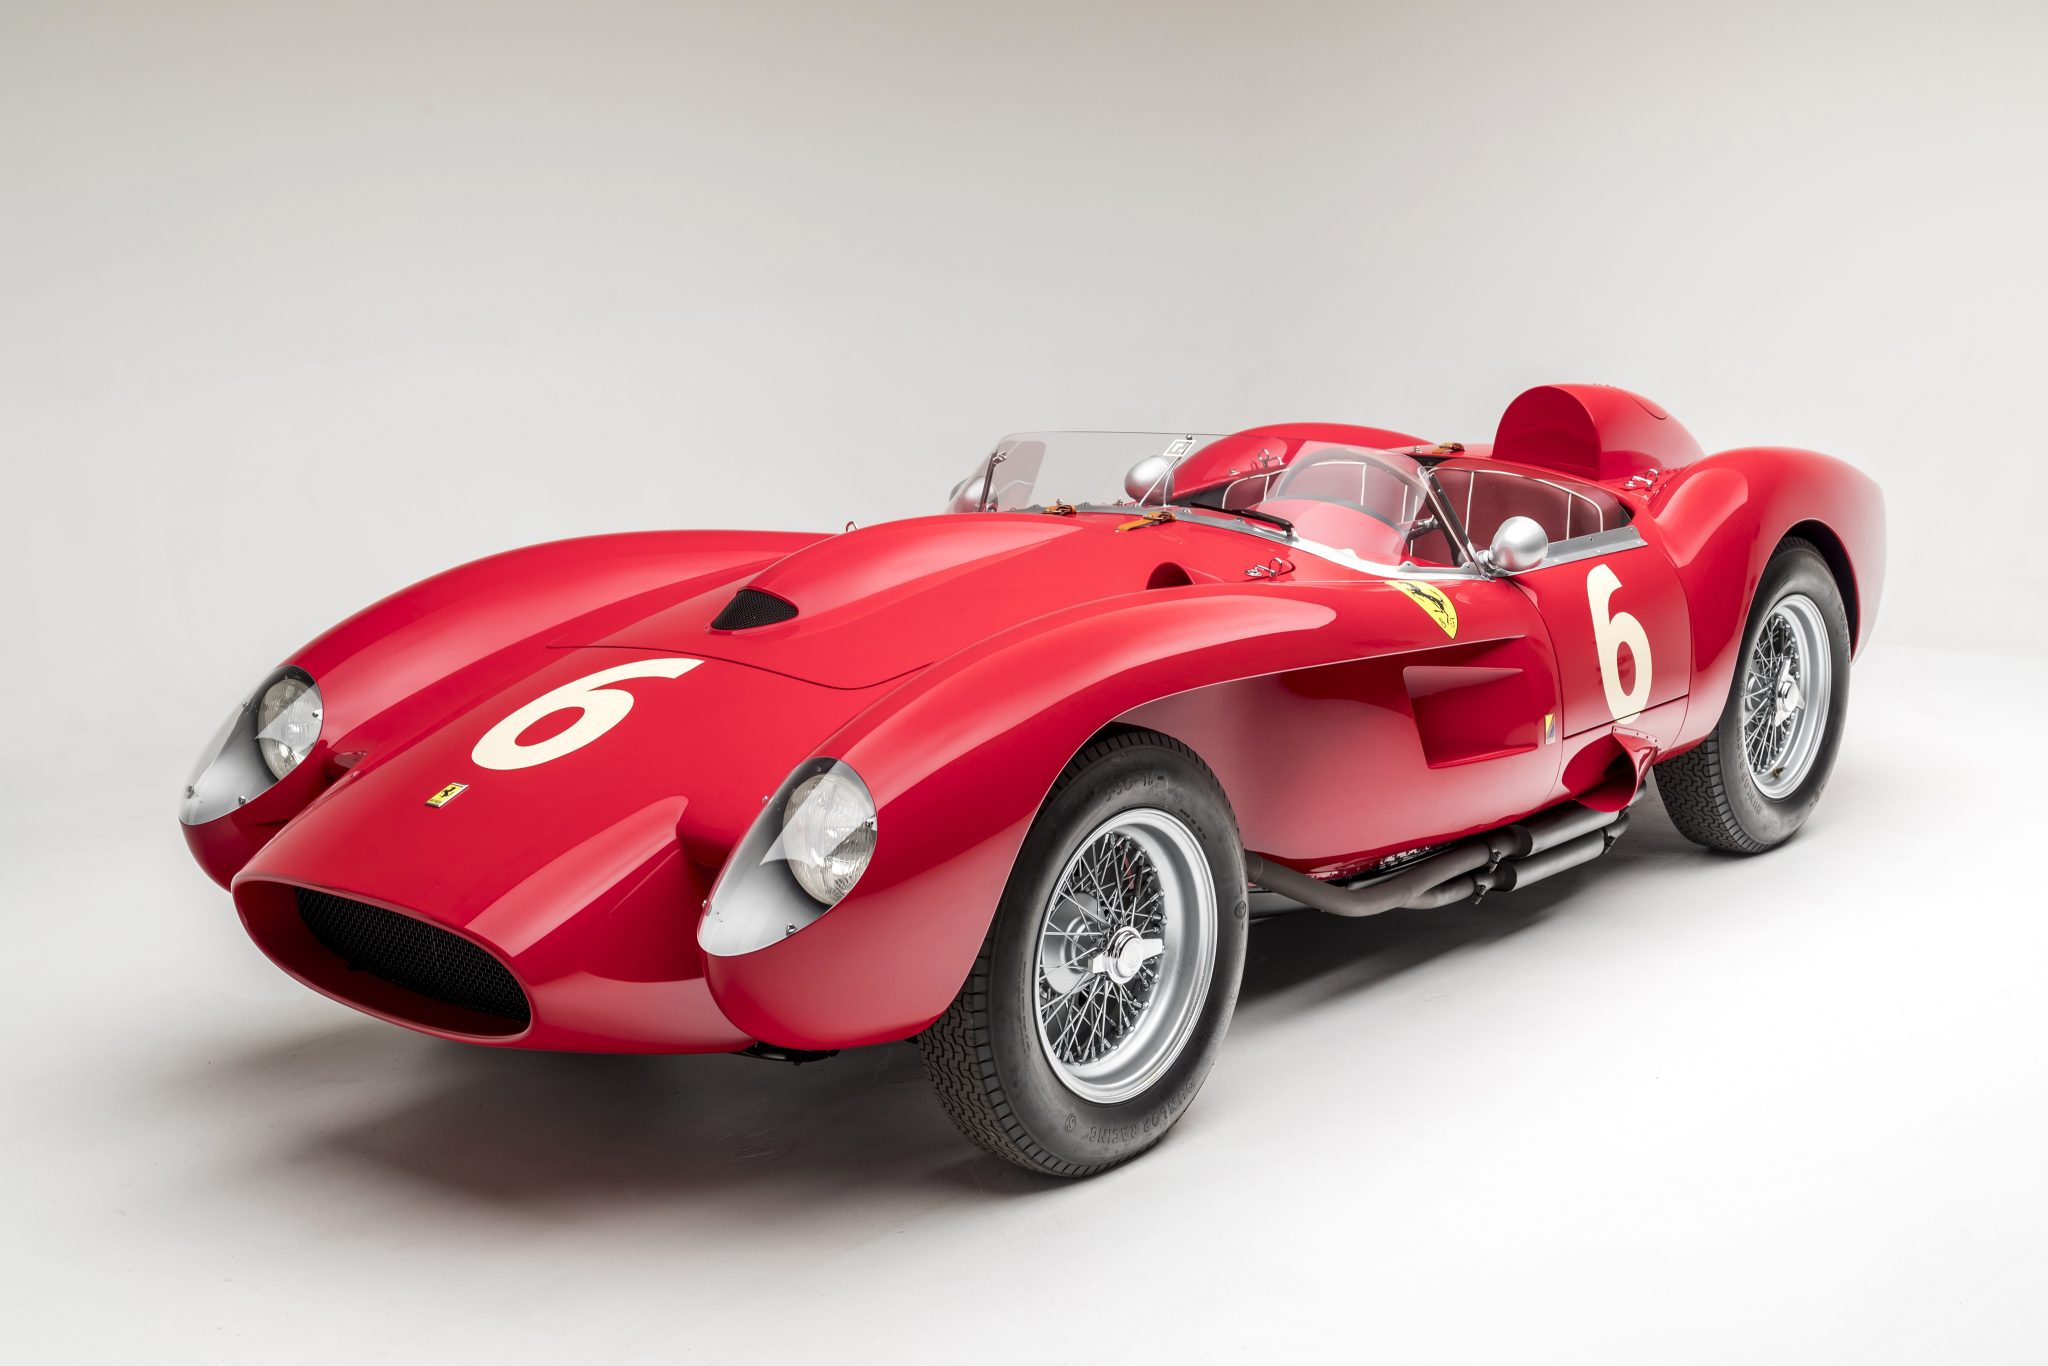

{
  "path": "./assets/Ferrari_250_GTO_1962.jpg",
  "model_name": "Ferrari_250_GTO_1962.jpg",
  "mediaType": "image"
}


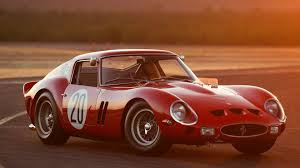

{
  "path": "./assets/Ferrari_250GT_Tour_de_France.jpg",
  "model_name": "Ferrari_250GT_Tour_de_France.jpg",
  "mediaType": "image"
}


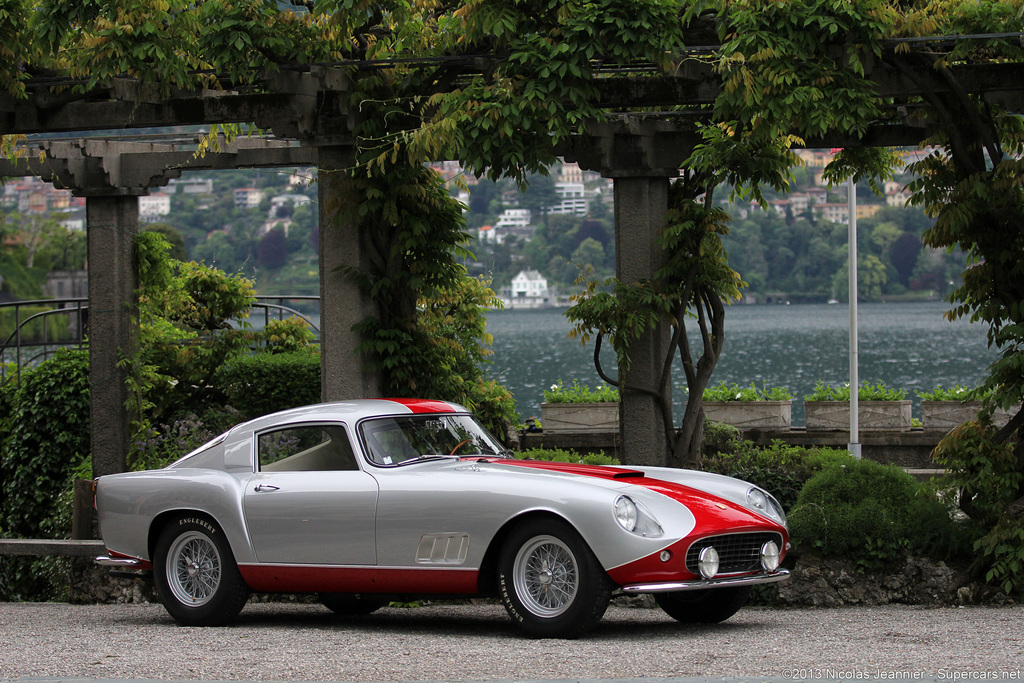

In [ ]:
# Local Image Search to Weaviate Collection

Ferrari_Search = client.collections.get("Ferrari")
response = Ferrari_Search.query.near_image(
    near_image=file_to_base64("C:/Users/user/Downloads/Ferrari_Model.jpg"),
    return_properties=['model_name','path','mediaType'],
    limit=3
)

print(f"Found {len(response.objects)} results:\n")
for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

Found 3 results:

{
  "path": "./assets/Ferrari_LaFerrari.jpg",
  "model_name": "Ferrari_LaFerrari.jpg",
  "mediaType": "image"
}


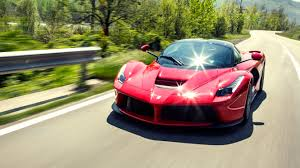

{
  "path": "./assets/Ferrari_SF90XX_Stradale.jpg",
  "model_name": "Ferrari_SF90XX_Stradale.jpg",
  "mediaType": "image"
}


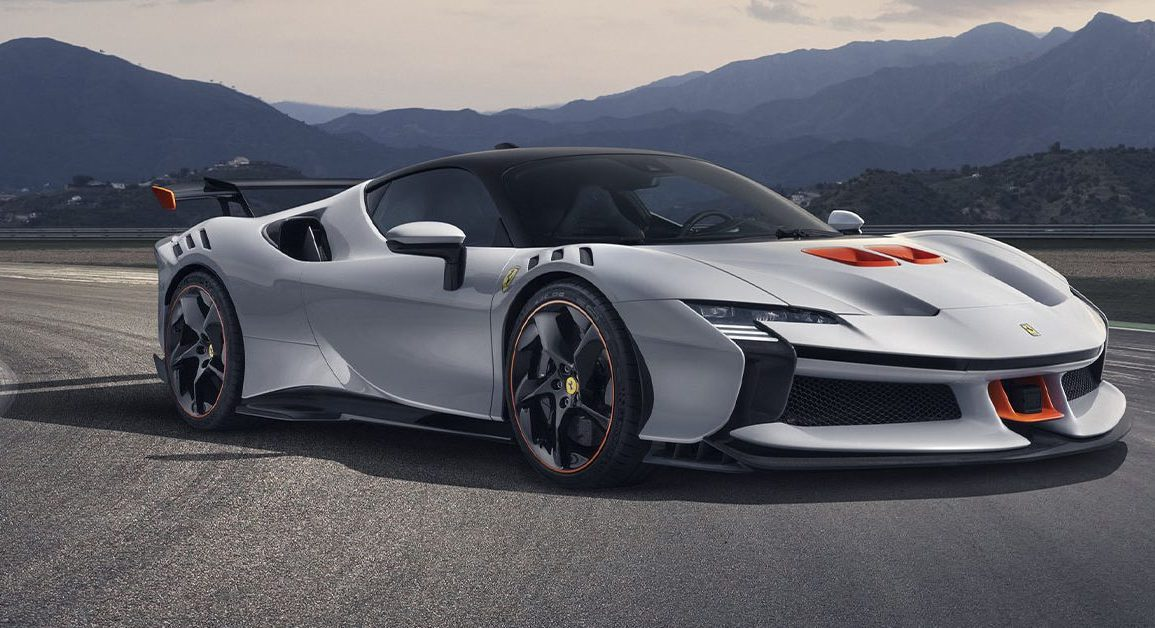

{
  "path": "./assets/Ferrari_599XX_Evo.png",
  "model_name": "Ferrari_599XX_Evo.png",
  "mediaType": "image"
}


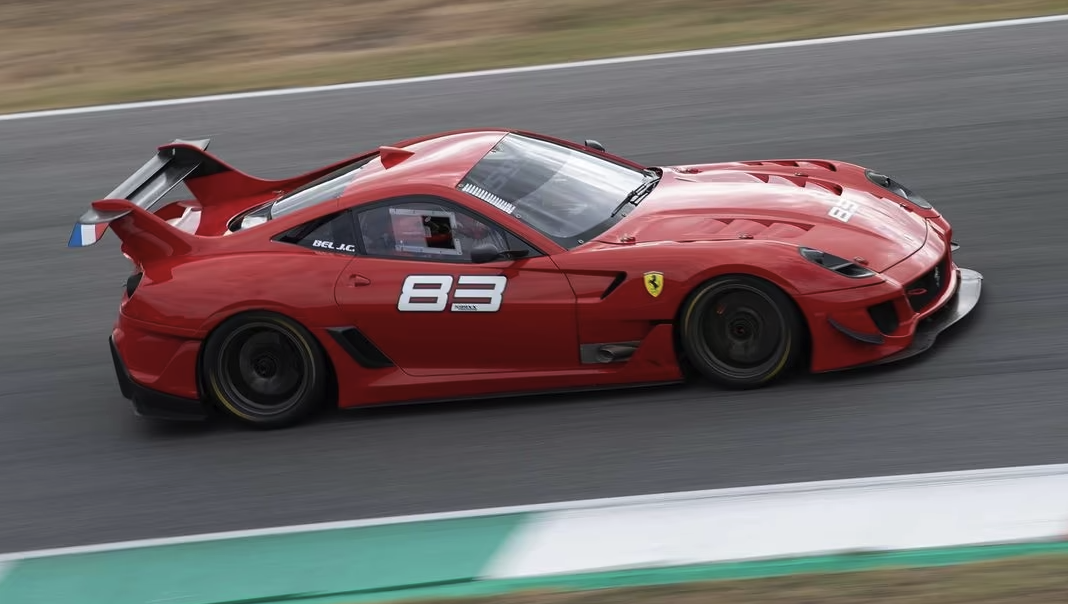

In [ ]:
# Step 12: URL Image to Weaviate Collection Search
# If you want to see the Ferrari Model used, copy only the Image URL in the Image function()

Image("https://media.wired.com/photos/59328215edfced5820d1110c/3:2/w_2560%2Cc_limit/141202_Ferrari-FXXK33056.jpg", width=300)
Ferrari_Search = client.collections.get("Ferrari")
response = Ferrari_Search.query.near_image(
    near_image=url_to_base64("https://media.wired.com/photos/59328215edfced5820d1110c/3:2/w_2560%2Cc_limit/141202_Ferrari-FXXK33056.jpg"),
    return_properties=['model_name','path','mediaType'],
    limit=3
)


# Display results
print(f"Found {len(response.objects)} results:\n")
for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)